In [3]:
!kaggle datasets download -d alifrahman/covid19-chest-xray-image-dataset



Dataset URL: https://www.kaggle.com/datasets/alifrahman/covid19-chest-xray-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 62% 25.0M/40.6M [00:00<00:00, 50.3MB/s]
100% 40.6M/40.6M [00:00<00:00, 70.7MB/s]


In [4]:
!unzip covid19-chest-xray-image-dataset

Archive:  covid19-chest-xray-image-dataset.zip
  inflating: dataset/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: dataset/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: dataset/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: dataset/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: dataset/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: dataset/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: dataset/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: dataset/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png  
  inflating: dataset/covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg  
  inflating: dataset/covid/1B734A89

In [5]:
# importing libraries
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
# Required imports
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [8]:
os.mkdir('test')

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split


In [10]:
# Define paths
main_folder = '/content/dataset'
normal_folder = os.path.join(main_folder, 'normal')
abnormal_folder = os.path.join(main_folder, 'covid')


train_folder = '/content/train'
test_folder = '/content/test'

# Create train and test folders if they do not exist
os.makedirs(os.path.join(train_folder, 'normal'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'covid'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'normal'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'covid'), exist_ok=True)


In [11]:
# Function to split data
def split_data(class_folder, train_class_folder, test_class_folder, test_size=0.2):
    files = os.listdir(class_folder)
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(class_folder, file), os.path.join(train_class_folder, file))

    for file in test_files:
        shutil.copy(os.path.join(class_folder, file), os.path.join(test_class_folder, file))


In [12]:
# Split normal data
split_data(normal_folder, os.path.join(train_folder, 'normal'), os.path.join(test_folder, 'normal'))

# Split abnormal data
split_data(abnormal_folder, os.path.join(train_folder, 'covid'), os.path.join(test_folder, 'covid'))

print('Data split into training and testing sets successfully.')

Data split into training and testing sets successfully.


In [13]:
# Define the data directory
data_dir = '/content'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
#image_datasets

In [14]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 75, 'test': 19}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


['covid', 'normal']

In [15]:
import torch

# Calculate the total number of images
total_images = dataset_sizes['train'] + dataset_sizes['test']

# Calculate the percentage of images in each dataset
train_percentage = (dataset_sizes['train'] / total_images) * 100
test_percentage = (dataset_sizes['test'] / total_images) * 100

# Print the percentages
print(f"Percentage of training images: {train_percentage:.2f}%")
print(f"Percentage of testing images: {test_percentage:.2f}%")

Percentage of training images: 79.79%
Percentage of testing images: 20.21%


In [16]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s]


In [17]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 3.9053 Acc: 0.4800
test Loss: 0.3019 Acc: 0.8421
train Loss: 0.5960 Acc: 0.7067
test Loss: 0.1110 Acc: 0.9474
train Loss: 0.3269 Acc: 0.8400
test Loss: 0.1120 Acc: 0.9474
train Loss: 0.3033 Acc: 0.8533
test Loss: 0.1114 Acc: 0.8947
train Loss: 0.1813 Acc: 0.9200
test Loss: 0.0650 Acc: 1.0000
train Loss: 0.3789 Acc: 0.8533
test Loss: 0.0761 Acc: 0.9474
train Loss: 0.3773 Acc: 0.8933
test Loss: 0.0697 Acc: 0.9474
train Loss: 0.4345 Acc: 0.8000
test Loss: 0.0616 Acc: 1.0000
train Loss: 0.3141 Acc: 0.8667
test Loss: 0.0738 Acc: 0.9474
train Loss: 0.3916 Acc: 0.8533
test Loss: 0.2277 Acc: 0.9474
train Loss: 0.2327 Acc: 0.9067
test Loss: 0.1093 Acc: 0.9474
train Loss: 0.1997 Acc: 0.9200
test Loss: 0.0487 Acc: 1.0000
train Loss: 0.1791 Acc: 0.9333
test Loss: 0.0519 Acc: 0.9474
train Loss: 0.3391 Acc: 0.8400
test Loss: 0.0680 Acc: 0.9474
train Loss: 0.2548 Acc: 0.9200
test Loss: 0.0636 Acc: 0.9474
train Loss: 0.0644 Acc: 1.0000
test Loss: 0.0479 Acc: 1.0000
train Loss: 0.2211 Acc: 

In [18]:

# Save the model
torch.save(model.state_dict(), '/content/covid19.pth')

In [26]:
from PIL import Image
# Load and preprocess the unseen image
image_path = '/content/dataset/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg'

image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [27]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['covid', 'normal']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: covid


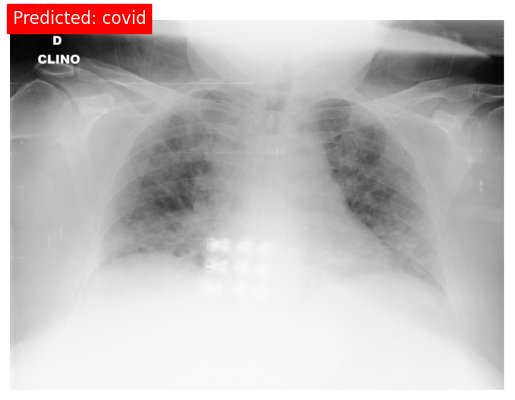

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [29]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset to collect true and predicted labels
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the calculated metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Accuracy: 0.9474
Precision: 0.9561
Recall: 0.9474
F1-score: 0.9488


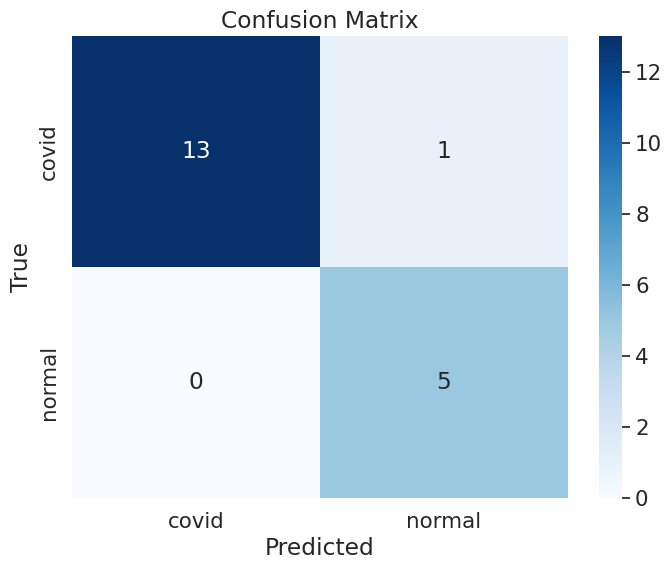

In [31]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the report
print(report)

              precision    recall  f1-score   support

       covid       1.00      0.93      0.96        14
      normal       0.83      1.00      0.91         5

    accuracy                           0.95        19
   macro avg       0.92      0.96      0.94        19
weighted avg       0.96      0.95      0.95        19



In [33]:
## hybrid resnet

In [34]:
import torch
from torch import nn
import torch.nn.functional as F


class DoubleAttention(nn.Module):

    def __init__(self, in_channels, c_m, c_n):

        super().__init__()
        self.c_m = c_m
        self.c_n = c_n
        self.in_channels = in_channels
        self.convA = nn.Conv2d(in_channels, c_m, kernel_size = 1)
        self.convB = nn.Conv2d(in_channels, c_n, kernel_size = 1)
        self.convV = nn.Conv2d(in_channels, c_n, kernel_size = 1)
        self.proj = nn.Conv2d(c_m, in_channels, kernel_size = 1)

    def forward(self, x):
        b, c, h, w = x.shape
        A = self.convA(x)  # (B, c_m, h, w) because kernel size is 1
        B = self.convB(x)  # (B, c_n, h, w)
        V = self.convV(x)  # (B, c_n, h, w)
        tmpA = A.view(b, self.c_m, h * w)
        attention_maps = B.view(b, self.c_n, h * w)
        attention_vectors = V.view(b, self.c_n, h * w)
        attention_maps = F.softmax(attention_maps, dim = -1)  # softmax on the last dimension to create attention maps
        # step 1: feature gathering
        global_descriptors = torch.bmm(tmpA, attention_maps.permute(0, 2, 1))  # (B, c_m, c_n)
        # step 2: feature distribution
        attention_vectors = F.softmax(attention_vectors, dim = 1)  # (B, c_n, h * w) attention on c_n dimension
        tmpZ = global_descriptors.matmul(attention_vectors)  # B, self.c_m, h * w
        tmpZ = tmpZ.view(b, self.c_m, h, w)
        tmpZ = self.proj(tmpZ)
        return tmpZ

if __name__ == "__main__":
    x = torch.randn(2, 64, 32, 32)
    attn = DoubleAttention(64, 32, 32)
    y = attn(x)
    print(y.shape)

torch.Size([2, 64, 32, 32])


In [35]:
# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.2538 Acc: 0.9067
test Loss: 0.1516 Acc: 0.9474
train Loss: 0.4807 Acc: 0.8000
test Loss: 0.0741 Acc: 0.9474
train Loss: 0.2222 Acc: 0.9067
test Loss: 0.0692 Acc: 0.9474
train Loss: 0.4673 Acc: 0.8800
test Loss: 0.2707 Acc: 0.9474
train Loss: 0.3389 Acc: 0.8933
test Loss: 0.0703 Acc: 0.9474
train Loss: 0.2342 Acc: 0.9067
test Loss: 0.1057 Acc: 0.9474
train Loss: 0.2756 Acc: 0.8933
test Loss: 0.0448 Acc: 1.0000
train Loss: 0.2255 Acc: 0.9467
test Loss: 0.1156 Acc: 0.9474
train Loss: 0.1543 Acc: 0.9467
test Loss: 0.0442 Acc: 1.0000
train Loss: 0.0805 Acc: 0.9600
test Loss: 0.0436 Acc: 1.0000
train Loss: 0.1579 Acc: 0.9333
test Loss: 0.1263 Acc: 0.9474
train Loss: 0.2895 Acc: 0.8667
test Loss: 0.0541 Acc: 0.9474
train Loss: 0.4390 Acc: 0.8400
test Loss: 0.0366 Acc: 1.0000
train Loss: 0.5050 Acc: 0.8533
test Loss: 0.1735 Acc: 0.9474
train Loss: 0.1990 Acc: 0.9200
test Loss: 0.0312 Acc: 1.0000
train Loss: 0.0840 Acc: 0.9467
test Loss: 0.0473 Acc: 1.0000
train Loss: 0.3699 Acc: 

In [36]:
# Save the trained model
torch.save(model.state_dict(), '/content/resnet18_with_double_attention.pth')

In [37]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Define transformations to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

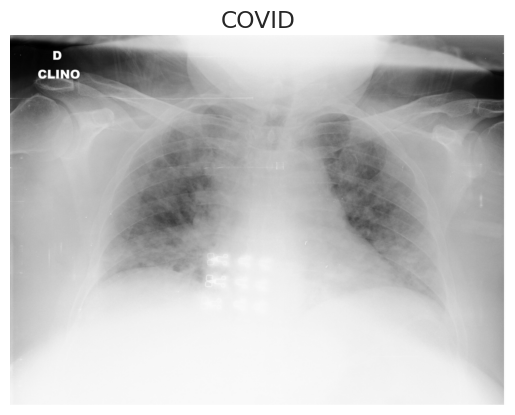

In [38]:
# Load the image
image_path = "/content/dataset/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg"


image = Image.open(image_path)



# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Move the input batch to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(input_batch)
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()  # Get the class index

# Define your class labels
class_names = ['COVID','NORMAL']

# Plot the image
plt.imshow(image)
plt.axis('off')

# Add the predicted class name as title
plt.title(class_names[predicted_class])

plt.show()


In [39]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset to collect true and predicted labels
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the calculated metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


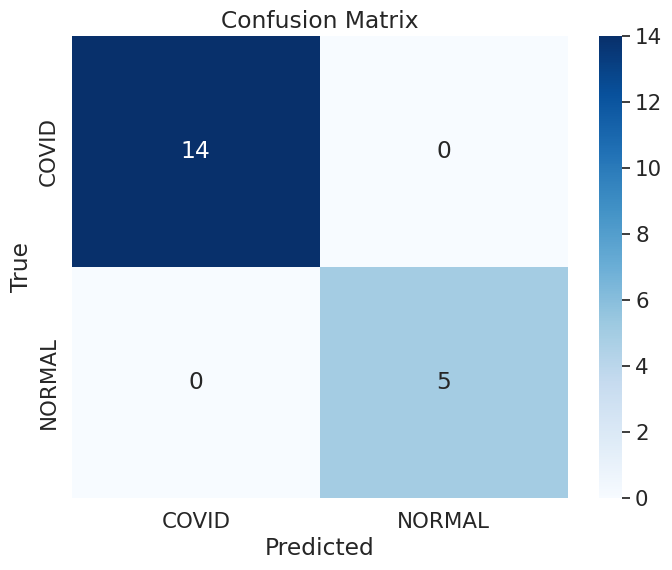

In [40]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [41]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the report
print(report)

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        14
      NORMAL       1.00      1.00      1.00         5

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

